# Mexico farms

This notebook explores the Mexico data following essentially the same steps as for the DMV poultry and NC pigs data (exploreUSAData notebook). The final output is a file containing farm and not-farm buildings.

## Setup

In [3]:
!pip install pyogrio==0.7.2 geopandas==0.14.3 -q

In [24]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"
pd.options.display.float_format = '{:.0f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Basic farm information

In [6]:
# Define the farm types we are interested in, and translate to English for ease
# of labelling plots etc.

farm_types = {'Granjas pollo ': 'Broiler', 'Granjas huevo': 'Layer',\
               'Granjas porcinos': 'Pig', 'Establos lecheros': 'Dairy',\
               'Corrales de Engorda': 'Feedlot'}

In [7]:
# Read the Mexico farm data

df_dict = pd.read_excel(
      f"{path}Mexico/Infraestructura pecuaria 2021.xlsx",
      sheet_name=None,
      header=3
      )

# Print some info about farm types
print("The government records contain these farm types:")
print([item[0] for item in df_dict.items()])
print(f"We will look at {farm_types.keys()}")

The government records contain these farm types:
['Granjas pollo ', 'Granjas porcinos', 'Granjas huevo', 'Corrales de Engorda', 'Establos lecheros', 'Unidades ovinas', 'Centro de Sacrificio']
We will look at dict_keys(['Granjas pollo ', 'Granjas huevo', 'Granjas porcinos', 'Establos lecheros', 'Corrales de Engorda'])


In [8]:
# Edit the df so it's easier to work with, and print a little info about the
# data.

all_farms = gpd.GeoDataFrame()
for farm_type, df in df_dict.items():

  if farm_type in farm_types.keys():

    df.drop(columns=['Nombre del Municipio', 'Nombre del Estado'], inplace=True)

    # Create geodataframe with columns for fam trypes and animal numbers
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
                                           df["Coordenada geográfica X"],
                                           df["Coordenada geográfica Y"]),\
                                           crs="EPSG:4326").drop(columns=\
                                           ["Clave Estado", "Clave Municipio",\
                                            "Coordenada geográfica X",\
                                            "Coordenada geográfica Y", "Estatus"])
    gdf.loc[:, "Farm type"] = farm_types[farm_type]
    gdf.loc[:, "Number of animals"] = np.nan

    print(f"\n There are {len(gdf)} {farm_type}")

    # Concatenate into an overall gdf containing all farms
    all_farms = pd.concat([all_farms, gdf])

print(f"\n There are {len(all_farms)} registered farms in total ")


 There are 1592 Granjas pollo 

 There are 2646 Granjas porcinos

 There are 844 Granjas huevo

 There are 2568 Corrales de Engorda

 There are 3100 Establos lecheros

 There are 10750 registered farms in total 


## Associate farms with buildings

First, narrow down the area of Mexico for which we need to collect building footprints. We only care about area where the farms are. Mexican states are divided into municipalities. There doesn't seem to be any further subdivision. So, while for Chile we had Region > Provincia > Comuna, for Mexico we have State > Municipio. They vary enormously in size.

In [9]:
# Read the admin district shapefile

munis = gpd.read_file(f'{path}Mexico/shapefiles/mex_admbnda_adm2_govmex_20210618.shp')
munis.crs="EPSG:4326"
munis = munis[['ADM2_ES', 'geometry']]
munis.rename(columns={'ADM2_ES':'Municipio'}, inplace=True)

In [10]:
# Create a df containing just the municipios that contain farms

# Find intersection of municipios and farms, retaining geometry of the parent
# farm
all_farms.loc[:, 'temp geom'] = all_farms.loc[:, 'geometry']
joined = munis.sjoin(all_farms, how='inner', predicate='intersects')

# Create df of municipios that contain farms
munis_w_farms = joined[~joined.index.duplicated(keep='first')]
munis_w_farms = munis_w_farms[munis.columns]
print(f"{len(munis_w_farms)} municipios contain farms")

# Create a df in which all these municipios are represented by a single
# multipolygon
single_geom = munis_w_farms.drop(columns=["Municipio"]).dissolve(by=None)

# Create df of farms with coords within these Municipios
mex_farms = joined[all_farms.columns].drop(columns=['geometry'])\
              .set_geometry('temp geom').rename(columns={"temp geom": "geometry"})

print(f"There are {len(mex_farms)} farms with coords within Mexican municipios")
for farm_type in farm_types.values():
  print(f" -- {len(mex_farms[mex_farms['Farm type'] == farm_type])} {farm_type} farms")


980 municipios contain farms
There are 10748 farms with coords within Mexican municipios
 -- 1592 Broiler farms
 -- 844 Layer farms
 -- 2646 Pig farms
 -- 3098 Dairy farms
 -- 2568 Feedlot farms


In [11]:
min_building_size = 400

In [12]:
%%skip
# Get buildings > min_building_size buildings and save for future use. This is
# time-consuming so don't run it unless there's a reason to recreate the file.

buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/MEX")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
)

utils.write_to_file(buildings_fc, f"buildings_{min_building_size}_sq_m", 'Mexico')
utils.ee_task_status()

In [13]:
buildings = gpd.read_file(\
            f"/content/drive/MyDrive/CAFO_data/Mexico/buildings_{min_building_size}_sq_m.geojson")
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m in Mexico")

There are 1218374 buildings > 400 sq m in Mexico


In [14]:
# Filter the buildings dataset to just the Municipios that contain registered
# farms

farm_muni_bldgs = buildings.sjoin(single_geom, how='inner', predicate='within')
farm_muni_bldgs = farm_muni_bldgs.filter(["Area (sq m)", "geometry"])
print(f"There are {len(farm_muni_bldgs)} buildings > {min_building_size} sq m in\
 the municipios with registered farms")

There are 887080 buildings > 400 sq m in the municipios with registered farms


In [15]:
# Find all the buildings that are within <farm_dist> m of a farm, and those
# that are more than <not_farm_dist> away

crs = "EPSG:6372"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(all_farms,\
                                                                  farm_muni_bldgs,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (any farm type) ")

There are 34327 buildings within 150 m of farm coords 
There are 748499 buildings >1000 m from farm coords (any farm type) 


In [16]:
new_total = 0
for farm_type in farm_types.values():
  n = len(all_farms[all_farms["Farm type"] == farm_type])
  print(f"Started with {n} farms of type {farm_type}")

  n = len(farm_buildings[farm_buildings["Farm type"] == farm_type].\
             groupby(by="Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 1592 farms of type Broiler
 -- 1541 are associated with buildings > 400 sq m
Started with 844 farms of type Layer
 -- 816 are associated with buildings > 400 sq m
Started with 2646 farms of type Pig
 -- 1951 are associated with buildings > 400 sq m
Started with 3100 farms of type Dairy
 -- 1607 are associated with buildings > 400 sq m
Started with 2568 farms of type Feedlot
 -- 980 are associated with buildings > 400 sq m
There is now a total of 6895 farms


In [17]:
# As we have done for other datasets, we'll drop all but the largest building
# per farm

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

34327 buildings --> 6828 buildings


In [18]:
# Calculate the lengths and aspect ratios of those buildings

max_farm_bldgs = explore.get_dimensions(max_farm_bldgs, crs=crs)

## Farm building characteristics

,5%-ile area (sq m),50%-ile area (sq m),95%-ile area (sq m)
Broiler,877,2138,3812
Layer,1012,2114,10788
Pig,457,1122,4966
Dairy,431,836,10329
Feedlot,426,870,6453


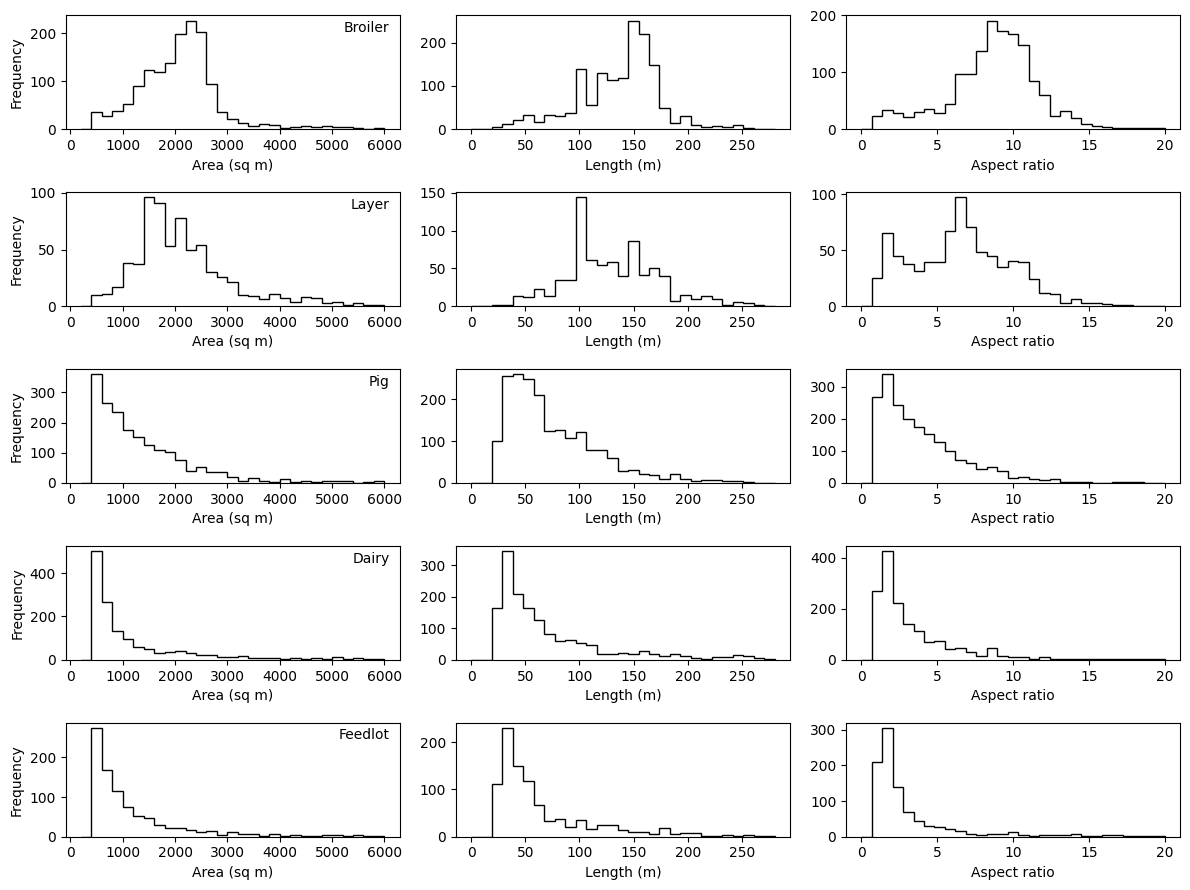

In [19]:
# Plot histograms for all farm types

bins = explore.define_bins()

df = pd.DataFrame()

_, axes = plt.subplots(5, 3, figsize=(12, 9))
for farm_type, ax in zip(farm_types.values(), axes):
  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  for col, a in zip(["Area (sq m)", "Length (m)", "Aspect ratio"],\
                    [ax[0], ax[1], ax[2]]):
    a.hist(to_plot[col], bins=bins[col], histtype='step', color='k')
    if col == "Area (sq m)":
      a.text(0.97, 0.95, farm_type, ha='right', va='top', fontsize=10,\
             transform=a.transAxes)
      a.set_ylabel("Frequency")
    a.set_xlabel(col)

  df.loc[farm_type, "5%-ile area (sq m)"] = to_plot["Area (sq m)"].quantile(0.05)
  df.loc[farm_type, "50%-ile area (sq m)"] = to_plot["Area (sq m)"].quantile(0.5)
  df.loc[farm_type, "95%-ile area (sq m)"] = to_plot["Area (sq m)"].quantile(0.95)

display(df)
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/Mexico_building_histos.png')

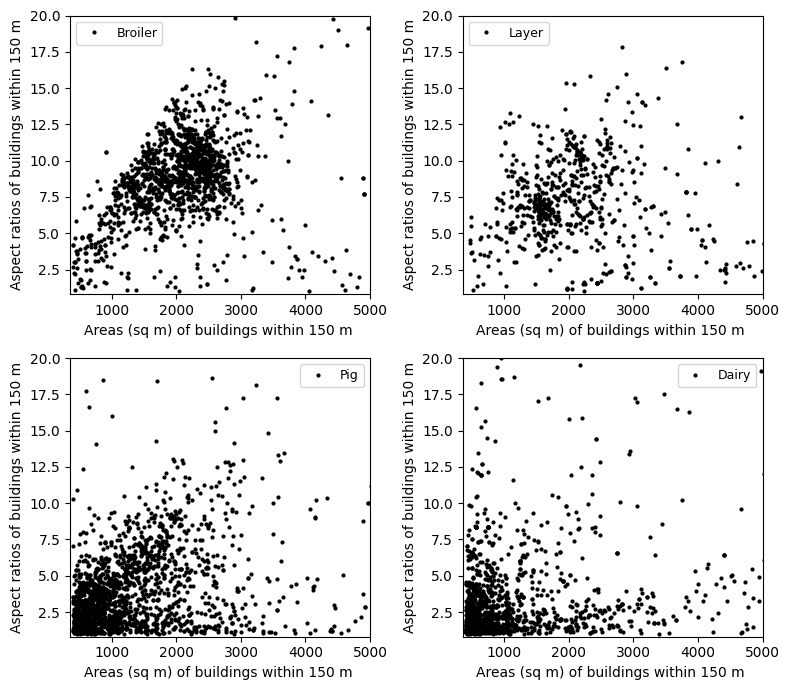

In [20]:
# Plot aspect ratio vs area for all farm types

_ , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 7))

for ax, farm_type in zip([ax1, ax2, ax3, ax4], farm_types.values()):

  # not bothering with feedlots
  if farm_type == "Feedlot":
    continue

  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  ax.plot(to_plot["Area (sq m)"], to_plot["Aspect ratio"], 'ko', ms=2,\
          label=farm_type)

  ax.legend(fontsize=9)
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Areas (sq m) of buildings within {farm_dist} m ')
  ax.set_ylabel(f'Aspect ratios of buildings within {farm_dist} m')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_aspect_area.png")

In [21]:
# Exclude dairy farms and feedlots

final_farms = max_farm_bldgs[~max_farm_bldgs["Farm type"].isin(["Dairy", "Feedlot"])]

## Visual inspection of farm sample

1. Pig farms with area < 800 sq m
  * Mainly recognisable as farms, although somewhat nonstandard. A few possible false positives, and some standard-type farms.
1. Pig farms with 1000 sq m < area < 2000 sq m AND aspect ratio < 2
  * Mixture of nonstandard(ish) farms, possible false positives
1. Pig farms with area ~3000 sq m, aspect ratio ~10
  * Standard large farms. Very distinctive.
1. Layer or broiler, area < 800 sq m
  * Mostly still standard-ish farms, some nonstandard, a few false positives

In [ ]:
to_check = final_farms[final_farms["Farm type"].isin(["Layer", "Broiler"])]
to_check = to_check[(to_check["Area (sq m)"] < 800)]
false_positives = explore.loop_over_buildings(to_check)

Working on feature 1 of 83


,geometry,Parent coords,Area (sq m),Farm type,Number of animals,Length (m),Aspect ratio
4911,"POLYGON ((-93.30984 16.75058, -93.31026 16.751...",POLYGON ((-93.30909779313271 16.75082503843193...,799,Broiler,NaN,68,6


Enter reject to reject, exit to exit, or any key to continue  exit


## The not-farm sample

There definitely is contamination in this sample, in the danger zone of large, long buildings. However, plenty of the "buildings" in that space are actually nurseries/greenhouses, terraced housing, industrial buildings, and ground-level artefacts. So while this dataset could be laboriously cleaned, again I think it's worth continuing as-is for now.

In [40]:
# First, filter any known CAFOs out of the other_buildings dataset. These have
# been collected and recorded during previous rounds of cleaning not-farm
# datasets. They probably mainly represent CAFO buildings where the CAFO coords
# are far from the buildings. There could also be some unregistered farms, and
# there's a handful of what look like defunct CAFOs as well.

bad = gpd.GeoDataFrame(pd.read_pickle(path+"Mexico/false_negatives.pkl"))
print(f"There are now {len(bad)} buildings in the false_negatives file")

def filter_bad(df1, df2, crs):

  df1.to_crs(crs, inplace=True)
  df2.to_crs(crs, inplace=True)

  # find any buildings within 1000 m of the known CAFO buildings
  common = df2.sjoin_nearest(df1, how='inner', max_distance=1000,\
                                       distance_col="Distance")
  filtered = df2[~df2.index.isin(common.index)].copy()
  filtered.to_crs("EPSG:4326", inplace=True)

  return filtered

filtered_notfarm = filter_bad(bad, other_buildings, crs)

# We are rejecting *all* buildings *near* the known CAFO ones. Because CAFOs
# generally have ,multiple buildings, this means we should end up rejecting more
# buildings than the number in the false_negatives file
print(f"Rejected {len(other_buildings) - len(filtered_notfarm)} buildings")

There are now 133 buildings in the false_negatives file
Rejected 2618 buildings


In [41]:
# Now get a stratified sample of not-farm buildings, like we did for NC. But
# which building size distribution should we match? Probably the overall
# distribution for pigs, layers, and broilers (not dairy though).

sampled = explore.stratified_sample(final_farms, filtered_notfarm, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'], factor=1.2)

notfarm_buildings = explore.get_dimensions(sampled, crs=crs)

notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

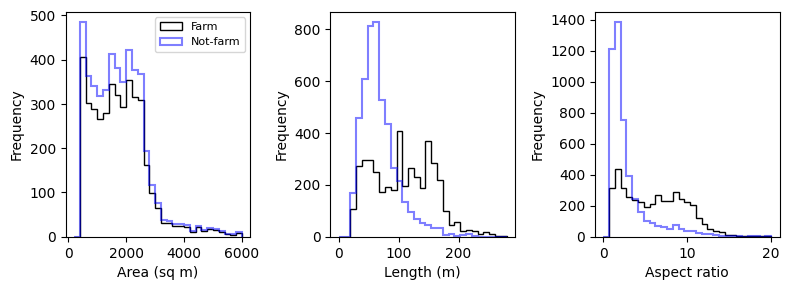

<Figure size 640x480 with 0 Axes>

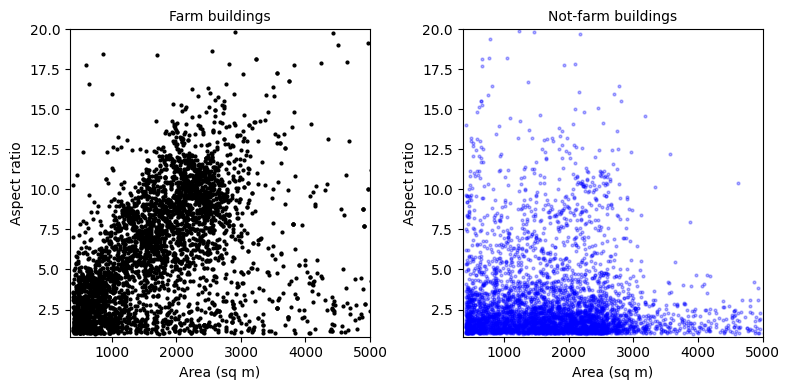

<Figure size 640x480 with 0 Axes>

In [42]:
# Plot histograms of all farm buildings (except dairy + feedlots) and all
# not-farm buildings. Also, aspect vs area plots

_, axes = plt.subplots(1, 3, figsize=(8, 3))

for ax, col in zip(axes, ["Area (sq m)", "Length (m)", "Aspect ratio"]):
  ax.hist(final_farms[col], bins=bins[col], histtype='step', color='k',\
          label="Farm")
  ax.hist(notfarm_buildings[col], bins=bins[col], histtype='step', color='b',\
          alpha=0.5, lw=1.5, label="Not-farm")
  if col == "Area (sq m)":
    ax.legend(fontsize=8)
  ax.set_ylabel("Frequency")
  ax.set_xlabel(col)
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_final_histos.png")

def axis_stuff(ax, label):
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Area (sq m)')
  ax.set_ylabel(f'Aspect ratio')
  ax.set_title(label, fontsize=10)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(final_farms["Area (sq m)"], final_farms["Aspect ratio"], 'ko', ms=2)
axis_stuff(ax1, "Farm buildings")
ax2.plot(notfarm_buildings["Area (sq m)"], notfarm_buildings["Aspect ratio"],\
        'bo', ms=2, alpha=0.3)
axis_stuff(ax2, "Not-farm buildings")
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_final_aspect_area.png")

In [46]:
to_check = notfarm_buildings[(notfarm_buildings["Area (sq m)"] > 1500) &\
                             (notfarm_buildings["Aspect ratio"] > 5)]
false_negatives = explore.loop_over_buildings(to_check[340:])

# Add any new false negatives to the file of known, existing ones
to_save = to_check.loc[false_negatives, :]
try:
  known_false_negatives = pd.read_pickle(path+"Mexico/false_negatives.pkl")
  to_save = pd.concat([known_false_negatives, to_save])
except FileNotFoundError:
  pass
to_save.to_pickle(path+"Mexico/false_negatives.pkl")

Working on feature 1 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4570,"POLYGON ((-107.51374 24.64611, -107.51345 24.6...",3341,185,10


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 2 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4598,"POLYGON ((-101.15516 27.88853, -101.15517 27.8...",3564,215,12


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 3 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4652,"POLYGON ((-115.40877 32.58388, -115.40902 32.5...",3649,144,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 4 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4670,"POLYGON ((-100.24784 25.75990, -100.24784 25.7...",3874,286,8


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 5 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4756,"POLYGON ((-99.05612 19.53119, -99.05628 19.531...",4620,219,10


Enter reject to reject, exit to exit, or any key to continue  n


Working on feature 6 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4795,"POLYGON ((-99.20094 23.88123, -99.20092 23.881...",5107,218,6


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 7 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4813,"POLYGON ((-100.99363 25.46799, -100.99392 25.4...",5358,172,6


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 8 of 8


,geometry,Area (sq m),Length (m),Aspect ratio
4818,"POLYGON ((-98.97038 19.79758, -98.97031 19.797...",5581,192,6


Enter reject to reject, exit to exit, or any key to continue  n


## The final training dataset

In [47]:
# Remove the CAFOs from the non-farm dataset
notfarms_cleaned = notfarm_buildings.drop(false_negatives)
print(f'Dropped {len(false_negatives)} CAFOs from the not-farm dataset')

print(f"\nThere are {len(notfarms_cleaned)} not-farms in the final training dataset")

Dropped 0 CAFOs from the not-farm dataset; adding to farm dataset

There are 4816 not-farms in the final training dataset


In [49]:
# Create the final files.

# -- Farm buildings
final_farms.loc[:, "Dataset name"] = "Mexico"
final_farms = explore.re_order(final_farms)
print(f"Saving {len(final_farms)} farms")

# -- Not-farm buildings
coldict = {"Dataset name": "Mexico", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarms_cleaned.loc[:, col] = val

notfarms_cleaned = explore.re_order(notfarms_cleaned)
print(f"Saving {len(notfarms_cleaned)} not-farms")

mex = pd.concat([final_farms, notfarms_cleaned])
mex.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/Mexico_bldgs.pkl')

Saving 4250 farms
Saving 4816 not-farms
